# Lab 8: Similarity-based Prediction with k-NN 📍

## Learning Objectives
- Loading local csv data into Pandas dataframe
- Preparing data for k-NN: Feature Transformation and Scaling
- Understanding and applying the k-NN algorithm
- Visualising k-NN decision boundaries

## Today's Lab
In today's lab we will investigate a simple similarity-based supervised ML algorithm and one way of making it more robust: feature transformations. 

**Similarity-based algorithms** use the data _directly_ to come up with insights or predictions instead of learning a model (parameterized function/relationship between variables). A commonly used similarity-based prediction algorithm is the k-Nearest-Neighbors, or k-NN algorithm. The specifics of this algorithm were covered in lecture, and here you will be able to see it applied in action, step by step.

**Feature transformations** refer to a set of algorithms that create new features in the data set based on the original set of given data. This is an important step in machine learning, because after transformation the data may develop more discriminatory power. An example of this would be converting nominal data types into _binary_ or _one-hot encoding_, such as turning "positive" and "negative" values into 1 and 0. Another example is scaling and normalizing data, which will be covered in this lab, and yet another example is feature selection and generation, which we will cover in the next module. 

## Outline

1. [Data Processing](#1.-Data-Processing)
2. [Feature Transformation and Scaling](#2.-Feature-Transformation-and-Scaling)
    1. [Explore the Feature Ranges](#Explore-the-Feature-Ranges)
    2. [Feature Scaling (Min-Max Scaling)](#Feature-Scaling-(Min-Max-Scaling))
    3. [Feature Standardization](#Feature-Standardization)
    4. [Do I Need to Scale?](#Do-I-Need-to-Scale?)
3. [k-Nearest Neighbors Algorithm](#3.-k-Nearest-Neighbors-Algorithm)
    1. [2D Data and k-NN Review](#2D-Data-and-k-NN-Review)
    2. [Implementing and Applying k-NN](#Implementing-and-Applying-k-NN)
    3. [k-NN Decision Boundaries](#k-NN-Decision-Boundaries)
    4. [What about Feature Scaling?](#What-about-Feature-Scaling?)

## 1. Data Processing

### Loading Our Data

In this lab, we will be revisiting our old friend, the Iris dataset — think pretty flowers from Lab 1. Recall that Iris is a multivariate data set that is used in linear discriminant analysis to quantify the morphologic variation of Iris flowers of three related species: _Iris setosa_, _Iris virginica_, and _Iris versicolor_. We will be looking at four characteristics that represent each species of flower — the sepal length, the sepal width, the petal length, and the petal width. 

<img src="utility/pics/irisFlowers.png" alt="iris" />

Normally, we would like to jump straight into using a NumPy array, but since the data has both numbers and strings, we must go through an intermediate step of encoding as we did in Lab 6 and homework 7. There are many ways of doing this. One way is by using [Pandas](https://pandas.pydata.org/) dataframes.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('utility/data/iris.csv')

### Dropping Duplicates and Encoding Variables

Let's drop the datapoints that have the same values for `sepal_length` and `sepal_width` and take a look at the first 5 rows of the data.

In [2]:

data = data.drop_duplicates(subset=['sepal_length','sepal_width']);

data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Notice that each row, example, has four features: `sepal_length`, `sepal_width`, `petal_length`, and `petal_width`. Each example also has a `species` value, which indicates the species this plant belongs to. If we were to create a prediction model, we would like to give it examples containing the four features and have it output a predicted species label.

#### Target Variable Encoding
Also notice that the categorical target varaible species is currently represetned by strings. In order to apply our mathematical formulas, we will have to encode these as [enumerated values](https://en.wikipedia.org/wiki/Enumeration). For example,

| Encoding | 0      | 1          | 2         |
| --------:|:------ |:---------- |:--------- |
| Species  | setosa | versicolor | virginica |

> [🐍 **Python Feature** 🐍]: Previously we used `sklearn` to encode target variables and features. Today we show you how you can **encodings** for simple repacements of strings with numbers in `pandas`.  We will create a dictionary that maps each species to the corresponding values in the table above and store it in `encoding`. We will then use it with the [`replace` 🔗](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html) method to apply the encoding to the species column in `data`.

In [3]:
encoding = {'setosa': 0, 'versicolor': 1, 'virginica': 2}

assert 'encoding' in globals(), 'Did you name your dictionary `encoding`?'
assert not (set(encoding.keys()) - set(data['species'].unique())), \
    'Double check that you have a mapping for each species'


# apply species encoding table to species column
encoded = data.copy() 
encoded['species'] = data['species'].replace(encoding)


assert np.all(encoded['species'].unique() == np.arange(3)), \
    'You should replace the values in data["species"]'

Let's take a look at the first five rows of the `encoded` again after your encoding.

In [4]:
encoded.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


At this point we should mention that in the real-world, we should also consider the possibility of missing values and outliers, as well as, perform a thorough EDA procedure (maybe with $k$-means clustering 😎). However, for the sake of time, and the fact that we have examined the Iris dataset in the past, we will skip this and move on.

### Pandas --> Numpy
Now that our data has been processed, let's pop it out of `pandas` and into `numpy`.

In [5]:
values = encoded.values
X, y = values[:, :4], values[:, 4]

## 2. Feature Transformation and Scaling 

First, let's do a train-test split, and assume for now the only data we have available is the **training data**. 

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5)

When working with large datasets, our dataset will contain features that vary highly in magnitudes, units, spread, and range. However, many algorithms, such as the `kNN` algorithm we are working with today, use Euclidean distance between two points in their computations. 
> Reminder: $$\|\pmb{p} - \pmb{q} \| = \sqrt{\sum_{j=1}^{d} (p_j - q_j)^2}$$

As you can see from this formula, features with much higher magnitues and spread will weigh in a lot more than features with smaller magnitudes, even though a smaller magnitude doesn't necessarily mean that it's less important! 

<img src="utility/pics/largeVsSmall.png" alt="small vs large"/>

For example, let's assume that one particular set of data has three features. The first feature is a property that ranges from 1-10, the second feature is a property that ranges from 1-100, and the last feature is a property that ranges from 1-10,000 (i.e. smaller changes in the larger feature can have disproportionately large effects). When training our classifier with this information, the kNN algorithm would take much more heavily into account the third feature when clustering because of its much more exaggerated difference in values when compared to the first or second features. This may lead to missed classifications. To avoid this, we need to normalize our data. 

> **Caution**: Avoid **data snooping**! Any feature analysis you perform before doing supervised learning has to be done based on the **training data set** _only_. We can't use knowlege about the data distribution coming from the test data, since this would perturb our evaluation results in a falsely favorable way. In other words, using the test data for anything else other than testing/evaluation would be _cheating_. 

### Explore the Feature Ranges

Execute the following cell to view the range of our features in the **training data**. 

In [7]:
print(f'''
Range of sepal length values: {X_train[:, 0].min()} ~ {X_train[:, 0].max()}
Range of sepal width  values: {X_train[:, 1].min()} ~ {X_train[:, 1].max()}
Range of petal length values: {X_train[:, 2].min()} ~ {X_train[:, 2].max()}
Range of petal width  values: {X_train[:, 3].min()} ~ {X_train[:, 3].max()}
''')


Range of sepal length values: 4.3 ~ 7.7
Range of sepal width  values: 2.0 ~ 4.4
Range of petal length values: 1.0 ~ 6.9
Range of petal width  values: 0.1 ~ 2.5



Notice how the ranges do vary between the features. We can also visualize the differences in ranges for each feature with a **box plot**.

In [8]:
import matplotlib.pyplot as plt
from utility.util import configure_plots

# to get pretty plots!
configure_plots()

Text(0.5, 1.0, 'Original Data')

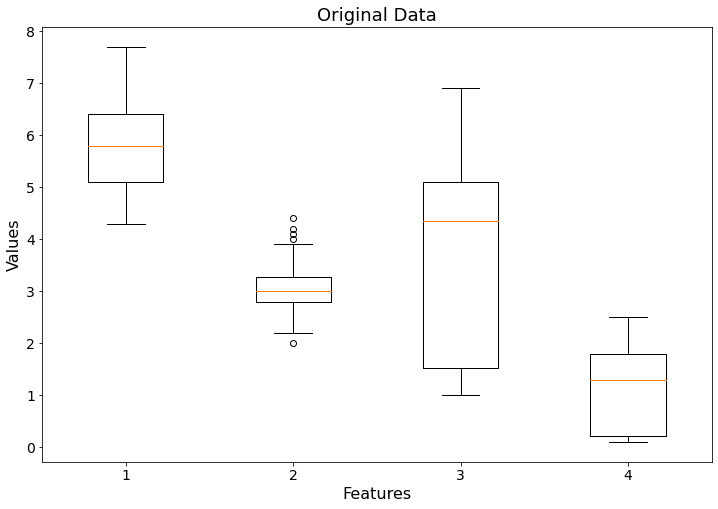

In [9]:
# repeat to get pretty plots the first time even
configure_plots()

plt.boxplot(X_train)
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Original Data')

**Write-up!** Discuss with your neighbors what kinds of information we can understand from a box plot. What is the orange line? What are the boxes? What are the whiskers, what are the dots? Note your answer in the cell below. 
>**Hint**: we covered some of this in `Lab1`.

**Your response here:** 


### Feature Scaling (Min-Max Scaling)

In order to not have one feature weighted more heavily than another, we must scale the data. Here, we scale features so that they exist within a 0-1 range (sometimes referred to as 'min-max scaling'). This can be done with this formula $$X_{\text{scaled}} = \frac{X - X_\min}{X_\max - X_\min}$$

> **Important**: We will need to make sure we use the same transformation on both our training and test sets. That means that we should scale `X_test` by the min and max of `X_train`.

This will be useful: **Broadcasting**

> [🐍 **Python Feature** 🐍]: In `numpy` it is possible to do operations on arrays of _different sizes_. In some case `numpy` can transform these arrays _automatically_ so that they all have the same size: this conversion is called **broadcasting**. Assuming we would do addition for a matrix `a` and a vector `b`, then `a+b` does sth like this: 

<img src="utility/pics/broadcasting_mat_vec.png" alt="Drawing" style="width: 600px;"/>

Look, it works!

In [10]:
A = np.array([[0, 0, 0],[10, 10, 10],[20,20,20],[30,30,30]])
print(A.shape)
b = np.array([0,1,2])
print(b.shape)
A+b

(4, 3)
(3,)


array([[ 0,  1,  2],
       [10, 11, 12],
       [20, 21, 22],
       [30, 31, 32]])

**Try this!** Complete the `min_max_scale` function so that it computes $X_{\text{scaled}}$ and store it into `X_scaled`. 

>**Hint** Remeber `numpy`'s braodcasting properties and use `numpy` operations (instead of `for` loops!!) and think about over which values you should take the `min` and `max` over.

In [13]:
def min_max_scale(X_in, min_scale_by=None, max_scale_by=None):
    ''' Computes the min-max scaled transformation of X_in
        * if min_scale_by or max_scale_by is None: compute the min and max based on X_in, then scale X_in
        * if min_scale_by and max_scale_by are proveded: use those to scale X_in. '''
    
    # only return scale parameters if they are computed on X_in
    return_scale_parameters = (min_scale_by is None) or (max_scale_by is None)
        
    # compute min if not provided
    if min_scale_by is None:
        min_scale_by = X_in.min(axis=0)

        
    #compute max if not provided
    if max_scale_by is None:
        max_scale_by = X_in.max(axis=0)

    
    print(min_scale_by.shape)
    print(X_in.shape)
    X_scaled = (X_in - min_scale_by)/(max_scale_by-min_scale_by) 

    
    assert isinstance(max_scale_by, np.ndarray), 'Compute the maximum for each feature dimension.'
    assert isinstance(min_scale_by, np.ndarray), 'Compute the minimum for each feature dimension.'
    assert X_scaled.shape == X_in.shape, 'The shape of the array X should not change'

    if return_scale_parameters:
        return X_scaled, min_scale_by, max_scale_by
    else: 
        return X_scaled

Let's try visualizing the changes made by our scaling procedure with a box plot. In the cell below, we recreate the plot we made earlier, but this time, create box plots for the scaled data.

(4,)
(98, 4)
(4,)
(18, 4)


Text(0, 0.5, 'Values')

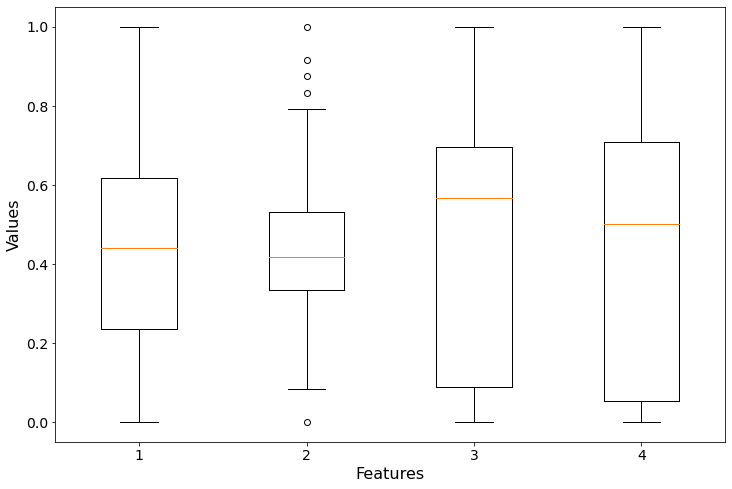

In [14]:
X_train_scaled, min_scale_by, max_scale_by = min_max_scale(X_train)
X_test_scaled = min_max_scale(X_test, min_scale_by, max_scale_by)

plt.boxplot(X_train_scaled)
plt.xlabel('Features')
plt.ylabel('Values')

**Write-up!** Discuss with your neighbors the differences you observed between your earlier plot and this plot. Write your answer in the cell below.

**Your response here:** 


### Feature Standardization

Another way to scale our data is to perform **standardization**, which is done by computing $$Z = \frac{X - \bar X}{\text{std}(X)},$$ where division is element-wise. Here, $Z$ is a matrix holding the standardized features in its columns. For those who are familiar with statistics (don't worry if you're not), this formula computes the [z-scores](https://en.wikipedia.org/wiki/Standard_score) for each value in $X$. The effect of this is to transform the data to have zero mean and unit variance (i.e. to be normally distibuted).

> **Note:** We will need to make sure we use the same transformation on both our training and test sets. That means that we should scale `X_test` by the mean and standard deviation of `X_train`.

**Try this!** Complete the `standardize` function so that it computes $Z$ and stores it in `Z`. 
> **Hint:**  Again, use `numpy` operations (instead of `for` loops!!) and think about over which values you should take the `mean` and `std` over.

In [15]:
def standardize(X_in, mean_scale_by=None, std_scale_by=None):
    ''' Computes the minstandardization of X_in
        * if mean_scale_by or std_scale_by is None: compute the min and max based on X_in, then scale X_in
        * if mean_scale_by and std_scale_by are proveded: use those to scale X_in. '''
    
    return_std_parameters = (mean_scale_by is None) or (std_scale_by is None)
        
    if mean_scale_by is None:
        mean_scale_by = X_in.mean(axis=0)

        
    if std_scale_by is None:
        std_scale_by = X_in.std(axis=0)

        
    Z = (X_in - mean_scale_by)/std_scale_by

    
    
    assert isinstance(mean_scale_by, np.ndarray), 'Compute the mean for each feature dimension.'
    assert isinstance(std_scale_by, np.ndarray), 'Compute the std for each feature dimension.'
    assert Z.shape == X_in.shape, 'The shape of the array X should not change'

    if return_std_parameters:
        assert mean_scale_by is not None, 'mean_scale_by not computed'
        assert std_scale_by is not None, 'std_scale_by not computed'
        return Z, mean_scale_by, std_scale_by
    else: 
        return Z

Let's try visualizing the changes made by our scaling procedure with a box plot. In the cell below, we, again, recreate the plot we made earlier, but this time, create box plots for the scaled data.

Text(0, 0.5, 'Values')

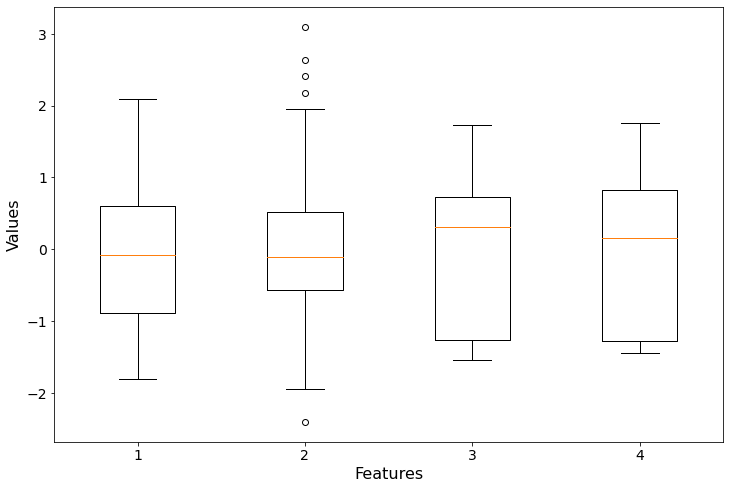

In [16]:
X_train_std, mean_scale_by, std_scale_by = standardize(X_train)
X_test_std = standardize(X_test, min_scale_by, max_scale_by)

plt.boxplot(X_train_std)
plt.xlabel('Features')
plt.ylabel('Values')

**Write-up!** Discuss with your neighbors the differences you observed between this plot and the 'min-max' scaled plot, as well as, why scaling to a range might be better than standardization and vice-versa. In what case would you use one over the other? Note your answer in the cell below.

**Your response here:** 


### Do I Need to Scale?

*As so often in machine learning*, the simple answer to this question is: it depends on the kind of **model** _and_ your **data set**! So, really we want to try it and compare the evaluation results (using a _validation set_ or _cross-validation_). We will do this for k-NN in the next part. 

However, there are models in which scaling has **zero effect** and hence does need to be tried. For example, scaling does **not** matter for **linear regression** when using the algorithm we derived in this course (i.e., using the analytic solution without a regularization term). 

**Write-up!** Can you explain why?

**Your response here:** 


## 3. k-Nearest Neighbors Algorithm

### 2D Data and k-NN Review
Although we are given four-dimensional input data (there are four features presented), we will only be using two dimensions in this analysis for ease of visualization, as it's easier to plot in two dimensions than it is to plot in four dimensions.

For this lab, let's ditch `petal_length` and `petal_width`. This means we will be left with `sepal_length` and `sepal_width`.

In [17]:
X_2D_train = X_train[:, :2]
X_2D_test = X_test[:, :2]

#### Reviewing k-NN Classification
Let's briefly revisit how the `kNN` algorithmn works with a two dimensional dataset, so that we can design one ourselves.

The `kNN` algorithm is known as a "lazy-learner," meaning that it doesn't actually make any computations in the training phase. After inputting our training data, the algorithm stores the data points and waits for us to input test features before making any computations. After loading our `sepal_length` and `sepal_width` data into our `kNN` algorithm, we are ready to start making predictions. 

1. As a first step our algorithm will calculate the Euclidean distance from each existing datapoint to our input point. 
2. The algorithm will then take the `k` nearest neighbors to our input data and calculate the **mode**, which is the label that appears the most frequently within the `k` neighbors. 
3. This value is returned as the predicted label for the test input. 

<img src="utility/pics/kNNgraph.png" alt="knn graph" />

In the graph above, `k = 6`. The points within the dotted circle are the 6 closet points to the star, which is our input point. 

**Write-up!** What is the **mode label** and what is the mode label's **frequency**? Would the star be classified as `Class A` or `Class B`? 

**Your response here:** 


### Implementing and Applying k-NN

We are ready to design our own k-NN algorithm and apply it to our flower species predicition problem using the sepal width and length as input features. 

Let's use the test input [$6.2, 3.1$].

In [18]:
x_star = np.array([[6.2, 3.1]])

print(X_2D_train.shape)
print(x_star.shape)

(98, 2)
(1, 2)


#### Distance Measure

As with k-Means, we will also need to have some distance measures here in order to compute the 'similarity' between our target point and those in our dataset. As mentioned earlier, Euclidean distance is a common choice. And, since you have already implemented it in `Lab7`, we will provide our implementation for you to use here.

> **Note:** The function below works for either two data points (vectors) `a` and `b` **or** for a feature matrix `a` and a vector `b`. In the latter case it will compute the difference of each row in the matrix `a` with `b` elementwise and then the norm is taken across the rows by providing the `axis=1` argument. The return variable is a (column) vector of distances. 

In [19]:
def compute_distances(a, b):
    '''Computes the Euclidean distance between point(s) a and b.'''
    
    distances = np.linalg.norm(a - b, axis=a.ndim > 1)

    assert distances.shape[0] == a.shape[0], 'You should return one distance for each point in X'
    
    return distances

In [20]:
distances_x_star = compute_distances(X_2D_train, x_star)

# test this / verify the output dimensions are correct
distances_x_star.shape

(98,)

#### Making Predictions

To make predictions, we will need to compute the distance between our target input point and every point in the dataset. And then we will need to find the labels of the $k$ closest points.

**Try this!** In the following cell, we implement the `get_closest_labels` function so that it computes the labels of the $k$ closest points for a _single_ array of distances. 

> **Hint:** The idea is to sort (or partially sort) the points by increasing distance
and then take the indices of the top-k closet ones. Use the [`np.argsort` 🔗](https://www.numpy.org/devdocs/reference/generated/numpy.argsort.html#numpy.argsort) or [`np.argpartition` 🔗](https://www.numpy.org/devdocs/reference/generated/numpy.argpartition.html#numpy.argpartition) to get the indices of the distance values ordered from smallest to largest first and then select the first `k` and use those to index into`y`. Store the resulting labels of the k-nearest neigbors in `labels`. 

In [21]:
def get_closest_labels(distances, y, k):
    '''
    Retrieves the labels of the k points that have the smallest distance
    given distances and labels y.
    '''
    
    sort = np.argsort(distances)
    labels = sort[:k]
    labels = y[labels]

    
    assert labels.shape[0] == k, 'You should return the labels of the k nearest neighbors'
    assert set(labels).issubset({0., 1., 2.}) , 'You should only get labels that are 0, 1, or 2.'
    
    return labels

Let's get the labels of the five closests points to input `x_star`. Check your implementation: using `k=5` you should get 
* the label `1` three times and 
* the label `2` two times.

In [22]:
print(get_closest_labels(distances_x_star, y_train, 5))

[1. 2. 1. 2. 1.]


Based on these labels, what should be our final predicted class label for this test point and which species is that? Let's implement this.

**Try this!** Complete the `predict` function so that it computes the final predicted labels of the points in `X_test` given `X_train`, `y_train`, and `k`. Make sure your function works for multiple test points. 
> **Hint**: you may iterate through each point in `X_test` using a `for` loop. Whenever you need to loop over the values in an array (or a list) while also needing the index, use [`enumerate` 🔗](https://docs.python.org/3/library/functions.html#enumerate). It gives you **both**, the index and the array/list entry. Refer to your implementation of `assign()` in `Lab7` under _Assigning Points to Clusters_.

In [29]:
from scipy.stats import mode
def predict(X_train, y_train, k, X_test):
    '''Computes the final prediction given the closest labels'''
    
    
    predictions = np.zeros(X_test.shape[0])
    
    for i, point in enumerate(X_test):
        distances = compute_distances(X_train, point)
        closest = get_closest_labels(distances, y_train, k)
        predictions[i] = mode(closest).mode
    

    
    assert predictions.shape[0] == X_test.shape[0], 'You should return the labels of the K nearest neighbors'
    
    return predictions

Now, let's test our `predict` function.

In [30]:
# test one input
y_hat = predict(X_2D_train, y_train, 3, x_star)
y_hat

array([1.])

In [31]:
# test matrix of two inputs
y_hat = predict(X_2D_train, y_train, 3, np.concatenate((x_star,x_star)))
y_hat

array([1., 1.])

#### Verify your Implementation 
Here is a quick visualization to verify the correctness of your implementations. Let's test our `predict` function on the entire test data `X_2D_test` and visualiz the predictions.

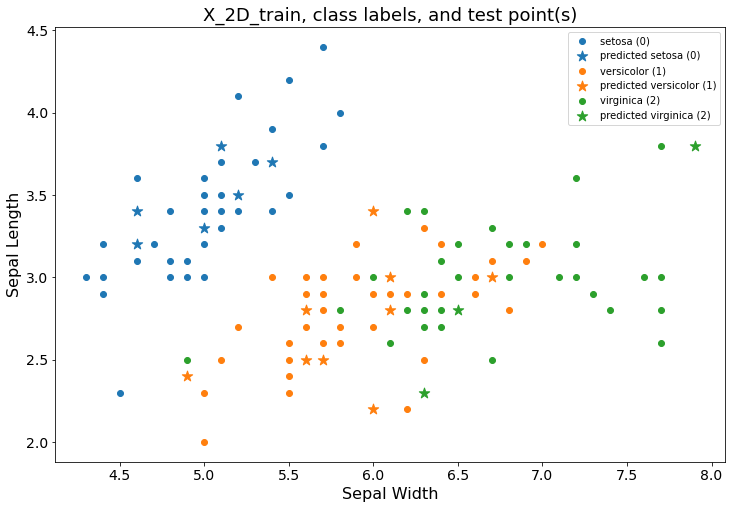

In [32]:
from utility.util import plt_data

my_k = 7
y_hat = predict(X_2D_train, y_train, my_k, X_2D_test)

# visulaize training and test data
plt_data(X_2D_train, y_train, encoding, X_2D_test, y_hat)

### k-NN Decision Boundaries
Unfortunately, the visualization above does not show us how accurate our kNN algorithm is since it does not visualize the **ground truth** (test observations). By executing the following cell of code, we can visualize this.
> **Note:** Each colored area represents the region where the input would be predicted as each of the three labels. The color of each point represents which class of species the features actually belong to (ground truth). 

C:\Users\Hyrul\Desktop\School\4 Semester\Intro to Data Science\Labs\Lab 8\lab8-groupe1\utility\util.py:82: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


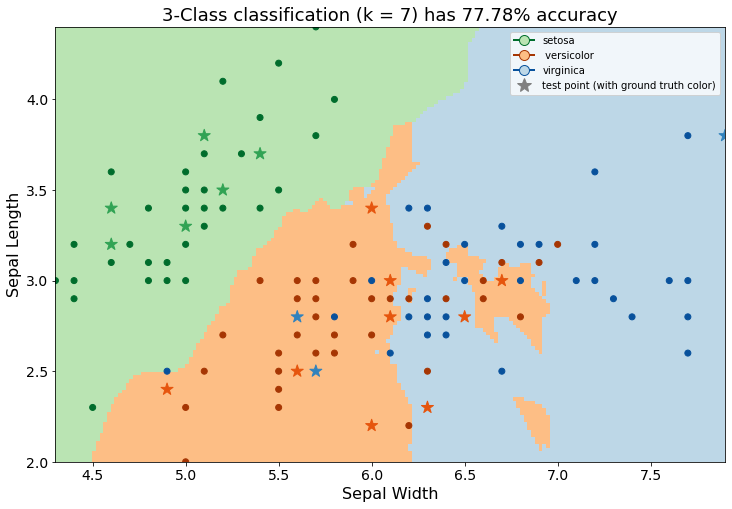

In [33]:
from utility.util import plot_knn

my_k = 7
plot_knn(X_2D_train, X_2D_test, y_train, y_test, k=my_k)

Consider the area in which Iris-`virginica` datapoints exist within the boundaries where the algorithm would have otherwise predicted for the species to be `versicolor`. Based on what you know about the algorithm, discuss these following questions: 

- Why have so many `virginica` datapoints been misclassified as `versicolor`?
- What would happen if we decreased the number of neighbors factored into the algorithm? Increased? **Try this!** Feel free to change the number of neighbors in the above cell to test your hypothesis.
- Is `kNN` a good algorithm for classifying these three species of flowers? Why or why not? 
- Is `kNN` a linear classifier? 

**Write-up!** Make notes of your answers. 

**Your response here:** 


### What about Feature Scaling? 
Does scaling have an effect on our k-NN algorithm? Let's scale our features and look at another graph to find out. In the previous plot, data was not scaled prior to training the algorithm.

We will check both `min_max_scale` and `standardize`. 

**Try this!** Min-max scale `X_2D_train` and `X_2D_test` appropriately and store the scaled training data in `X_2D_train_scaled` and the scaled test data in `X_2D_test_scaled`. Plot the decision boundaries using `plot_knn`.
> **Hint**: use the min and max used to scale the training set to **also** scale the testing set.

In [41]:
X_2D_train_scaled, min_scale_by, max_scale_by = min_max_scale(X_2D_train)
X_2D_test_scaled = min_max_scale(X_2D_test, min_scale_by, min_scale_by)


assert X_2D_test_scaled.min()!=0.0 and X_2D_test_scaled.max()!=1.0, \
            'Use the min and max of the training data to scale your test data.'

(2,)
(98, 2)
(2,)
(18, 2)


C:\Users\Hyrul\miniconda3\envs\cse217a\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


**Try this!** Standardize `X_2D_train` and `X_2D_test` appropriately and store the standardized training data in `X_2D_train_std` and the scaled test data in `X_2D_test_std`. Plot the decision boundaries using `plot_knn`.

> **Hint**: use the mean and std used to scale the training set to **also** scale the testing set.

In [ ]:
# your code here 


assert X_2D_test_std.mean()!=0.0 and X_2D_test_std.std()!=1.0, \
            'Use the min and max of the training data to scale your test data!'

**Write-up!** Do you notice any differences? Which version of `kNN` works best for `my_k = 5`?

**Your response here:** 


Great! Now, we have **selected** our data transformation method (and hyperparameter k). 

**Write-up!** Did we forget anything? What do you tell your boss, if she asks you how well your approach works for _unseen_ data? 

**Your response here:** 


**Awesome! Now that we've implemented k-NN by ourselves and investigated (some of) its workings, we can comfortably use the k-NN function provided by SciKit Learn (cf. `hw8`).**